# Eda and word2vec

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud
import spacy
nlp = spacy.load('en_core_web_sm')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.ticker import FuncFormatter
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here we will work with only  papers file which has been already preprocessed file.

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ai-5/papers_with_abstract_cleaned.csv")
data.head()

,Unnamed: 0,Unnamed: 0.1,source_id,year,title,abstract,full_text
0,0,0,27,1987,Bit-Serial Neural Networks,a bit serial vlsi neural network is described ...,bit serial neural networks alan f murray antho...
1,1,1,63,1987,Connectivity Versus Entropy,how does the connectivity of a neural network ...,connectivity versus entropy yaser s abu mostaf...
2,2,2,60,1987,The Hopfield Model with Multi-Level Neurons,the hopfield neural network model for associat...,the hopfield model with mul ti level neurons m...
3,3,3,59,1987,How Neural Nets Work,there is presently great interest in the abili...,alan lapedes robert farber theoretical divisio...
4,4,4,69,1987,Spatial Organization of Neural Networks: A Pro...,the aim of this paper is to explore the spatia...,spatial organization of neural nen orks a prob...


In [ ]:
print(data.columns)
print(len(data.columns))

Index(['Unnamed: 0', 'Unnamed: 0.1', 'source_id', 'year', 'title', 'abstract',
       'full_text'],
      dtype='object')
7


In [ ]:
data.shape

(9312, 7)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9312 entries, 0 to 9311
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    9312 non-null   int64 
 1   Unnamed: 0.1  9312 non-null   int64 
 2   source_id     9312 non-null   int64 
 3   year          9312 non-null   int64 
 4   title         9312 non-null   object
 5   abstract      9311 non-null   object
 6   full_text     9304 non-null   object
dtypes: int64(4), object(3)
memory usage: 509.4+ KB


In [ ]:
data.isnull().sum()

Unnamed: 0      0
Unnamed: 0.1    0
source_id       0
year            0
title           0
abstract        1
full_text       8
dtype: int64

Text(0.5, 1.0, 'Frequency showing number of papers released in different years')

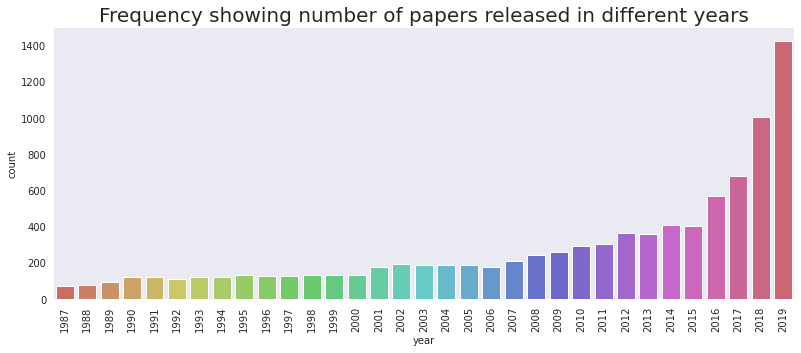

In [ ]:
sns.set_style("dark")
graph = sns.catplot(data=data, x="year", kind="count", height = 4.5, aspect = 2.5, palette = "hls")
graph.set_xticklabels(rotation=90)
plt.title("Frequency showing number of papers released in different years", size = 20)

So the above chart represents that in our dataset most papers got released for the year 2019. Now let's look at the text a little.

In [ ]:
pd.set_option('display.max_colwidth', None)
data["full_text"].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Hmmm... So our text size is quite big. Let's find out word-size for the texts using histogram. 

In [ ]:
data['Number_of_words'] = data['full_text'].apply(lambda x:len(str(x).split()))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

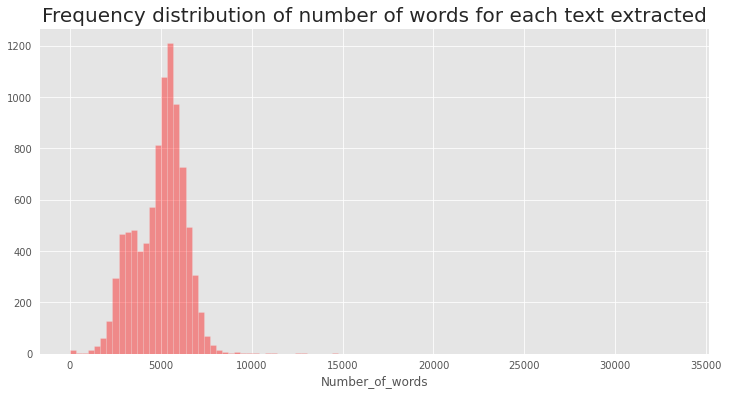

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(data['Number_of_words'],kde = False,color="red", bins = 100)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

Text(0.5, 1.0, 'Word frequency distribution using Box plot')

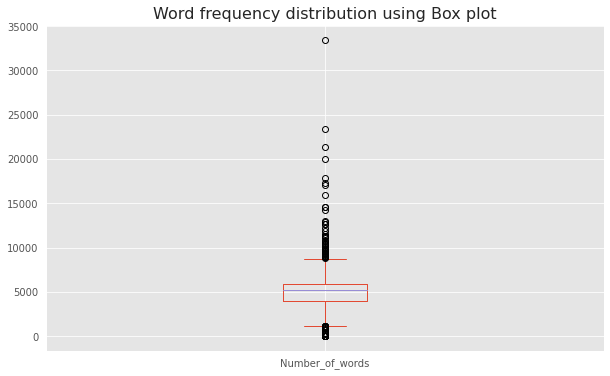

In [ ]:
plt.figure(figsize = (10,6))
data["Number_of_words"].plot(kind="box")
plt.title("Word frequency distribution using Box plot", size = 16)

In [ ]:
data.drop(data[data["Number_of_words"]<200].index, inplace = True)

So using the above code I have removed all the texts which are less than 200 words, basically there were only 3 rows, which contains data of this small size.

In [ ]:
data.shape

(9302, 8)

Now we will try to see how many documents have words count between 200 and 500.

In [ ]:
len(data[(data["Number_of_words"]>200) & (data["Number_of_words"]<500)])

5

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted after removing 3 columns')

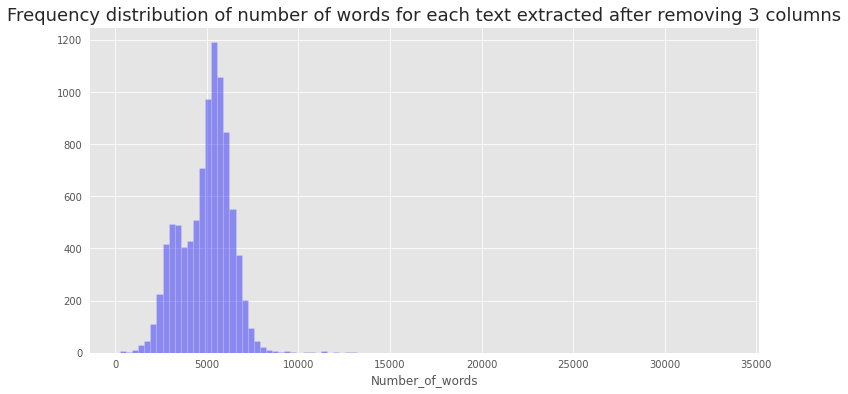

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(data['Number_of_words'],kde = False,color="blue", bins = 100)
plt.title("Frequency distribution of number of words for each text extracted after removing 3 columns", size=18)

Now we will do the next step cleaning process which is stop word removal and then we will lemmatize the words.

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
##Creating a list of custom stopwords
new_words = ["fig","figure","image","sample","using", 
             "show", "result", "large", 
             "also", "one", "two", "three", 
             "four", "five", "seven","eight","nine","cid"]
stop_words = list(stop_words.union(new_words))

def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    # remove stopwords
    text = [word for word in text if word not in stop_words]

    # remove words less than three letters
    text = [word for word in text if len(word) >= 3]

    # lemmatize
    lmtzr = WordNetLemmatizer()
    text = [lmtzr.lemmatize(word) for word in text]
    
    return ' '.join(text)

In [ ]:
data["lemmatize_joined"]=data["full_text"].apply(lambda x:pre_process(x))

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Now let's try to create a wordcloud from this cleaned text.

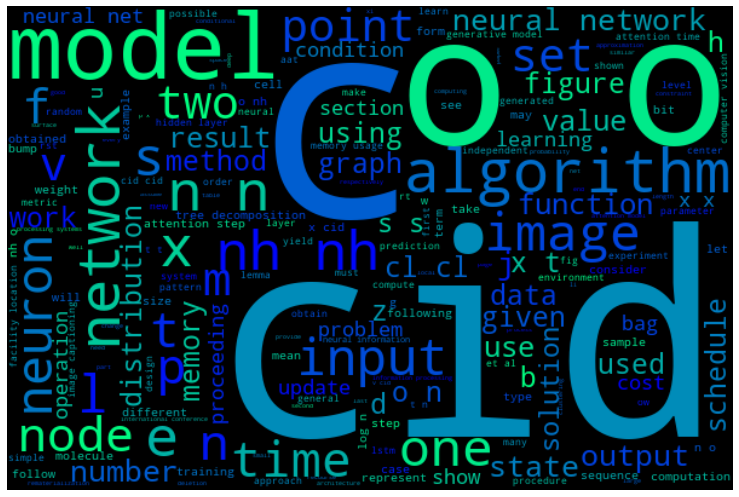

In [ ]:
cloud=WordCloud(colormap="winter",width=600,height=400).generate(str(data["full_text"]))
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

In [ ]:
data["lemmatize_joined"].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Now let's see how the word distribution has changed using a histogram after doing some text cleaning.

In [ ]:
data['Number_of_words_for_cleaned'] = data['lemmatize_joined'].apply(lambda x:len(str(x).split()))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted after removing stopwords and lemmatization')

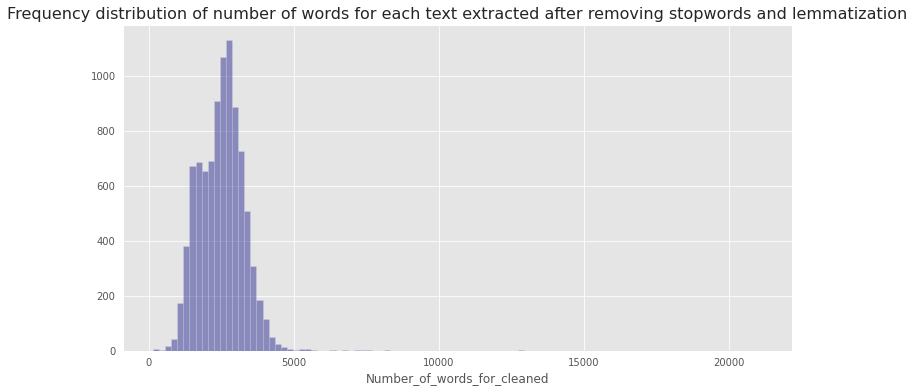

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(data['Number_of_words_for_cleaned'],kde = False, color= "navy", bins = 100)
plt.title("Frequency distribution of number of words for each text extracted after removing stopwords and lemmatization", size=16)

So we can clearly see the shift after stopword removal. Now let's see the top 30 most frequent words in our whole text. Also let's remove documents with word size more than 6000, cause we don't want to deal with at the moment a document of this size.

In [ ]:
data.drop(data[data["Number_of_words_for_cleaned"]>4500].index, inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of no of words in the documents after removing docs containing > 4500 words')

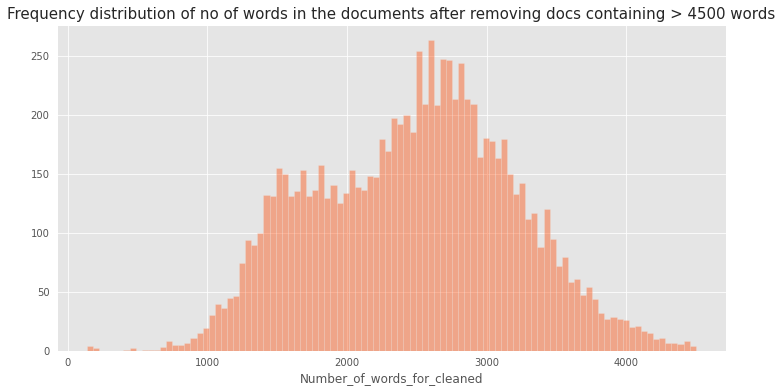

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(data['Number_of_words_for_cleaned'],kde = False, color= "orangered", bins = 100)
plt.title("Frequency distribution of no of words in the documents after removing docs containing > 4500 words", size=15)

Text(0.5, 1.0, '30 most frequent words')

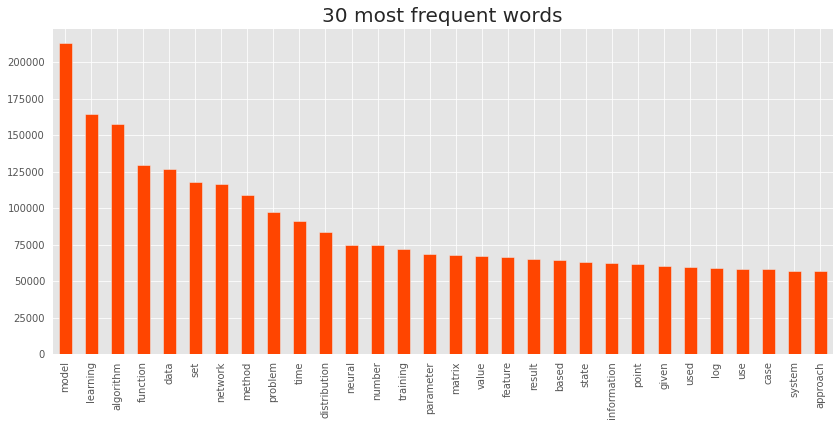

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=pd.Series(" ".join(data["lemmatize_joined"]).split()).value_counts()[:30]
freq.plot(kind="bar", color = "orangered")
plt.title("30 most frequent words",size=20)

So in the above we can see that there are still some stopwords present, but I want to keep them, as they are adding some meaning to our text. Now let's do vectorization, using 

# Vectorization using Word2vec

Before begining, word2vec takes list of words as an input to train the neural network model. Word2vec is a neural network with 1 hidden layer. Input layer takes the vocabulary of words, and hidden layer's size is the vector size of the word that we want, so here we will be giving 250 as the hidden layer size or we want size of the vectors for each word to be 250.

In [ ]:
tokens = data["lemmatize_joined"].apply(lambda x: nltk.word_tokenize(x))

So what's happening below is we are giving the list of words, and we are limiting some words, meaning, we are allowing those words in our vocabulary in the model, whose frequency is more than 600 using **min_count**, as we want a little cleaner t-sne plot, otherwise the plot will be a huge mess, as their are too much words in our data, so to make it a little cleaner, I just limited it to the words which has a frequency of above 600, also the vector size of a word here will be 250 and we defined it using **size**, and for **window** 10 mean, for a word, it will look 10 words right to it and 10 words to it's left. **Alpha** and **min_alpha** are the learning rates, so we will start with the learning rate of 0.03, and later near optimization, the learning rate will lower down to 0.0007, to find the optimized weights.

In [ ]:
w2v_model = Word2Vec(tokens,
                     min_count=600,
                     window=10,
                     size=250,
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers = 4,
                     seed = 42)

Now let's see the vector representation of the word "model".

In [ ]:
v1 = w2v_model.wv['model']
print(v1)

[ 1.8252631   0.77237475 -0.23003078 -1.5214871  -1.4194605   0.12183432
  0.35319695  0.7279531  -0.20682025 -0.43389022 -0.18357804 -0.01785752
  2.0068552  -1.3330727  -0.9828825   1.6118733   0.55883443  0.9532357
  1.354775   -0.8048767   1.1884313  -2.368282    1.9072561  -1.9446529
  0.73598504  1.9363651  -1.7324063  -0.6517826  -0.5884837   0.31207517
  1.0166551  -1.6932335  -0.48161218 -0.48056525 -1.2150156  -1.948885
  0.49827302  0.16675356 -0.13759111 -0.47398686  2.196452    0.33362377
 -0.22106193  0.3795929  -1.7620748  -0.27025184 -0.05389184 -2.1396303
 -0.7421173   1.5033911  -0.5010932   0.24836467 -1.6379207   0.30562228
 -0.17667578 -1.2869093  -1.6722422  -0.08691865 -0.5127808   1.4000531
 -0.30902135  0.7274385   1.6238132  -0.54259706  1.6119052   0.8641463
  1.3300846   0.8743299   0.57406396  0.84544235  2.6139233  -1.8273711
  0.42493886  0.98894316 -2.1517322   0.25385907  0.05844138 -0.7603966
 -1.1966143  -0.17844665 -0.5522673   1.0707599   0.8036878 

So it's a vector of 250 numbers, as described by us while creating the model, and each dimension represents some aspect of the word. Now let's see some similar words.

# Similar words using Word2vec

In [ ]:
sim_words = w2v_model.wv.most_similar('estimator')
print(sim_words)

[('estimate', 0.5819286704063416), ('estimation', 0.5351728796958923), ('unbiased', 0.4926440715789795), ('plug', 0.4914734363555908), ('mle', 0.4874953329563141), ('asymptotically', 0.43013131618499756), ('estimating', 0.42126578092575073), ('asymptotic', 0.4159718155860901), ('bootstrap', 0.3690109848976135), ('variance', 0.3610077202320099)]


In [ ]:
sim_words_2 = w2v_model.wv.most_similar('synapse')
print(sim_words_2)

[('synapsis', 0.7097213268280029), ('synaptic', 0.6505337953567505), ('postsynaptic', 0.5815808176994324), ('presynaptic', 0.5614585280418396), ('voltage', 0.5582072138786316), ('pulse', 0.5341742634773254), ('conductance', 0.5272481441497803), ('neuron', 0.512147843837738), ('membrane', 0.5040870308876038), ('chip', 0.48657411336898804)]


In [ ]:
sim_words_3 = w2v_model.wv.most_similar('connectivity')
print(sim_words_3)

[('connection', 0.4814006984233856), ('brain', 0.46658557653427124), ('excitation', 0.4651550054550171), ('activity', 0.4602348208427429), ('cortical', 0.4438963830471039), ('fmri', 0.4289977252483368), ('adjacency', 0.41141456365585327), ('coupling', 0.40274956822395325), ('inhibition', 0.3939237892627716), ('neuronal', 0.39280545711517334)]


# TSNE Plot for 2 models

About T-SNE, it is mainly used for showing high dimensional figure to a lower dimensional figure. So here, as we know the words has a dimension of 250, and we are showing it in 2-D figure, just imagine! This is the job of T-SNE. So the concept says, similar words will have similar vectors, and so those similar words will be closer in the vector space, or sometimes may even overlap, if they are too similar.

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=2000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15, 13)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


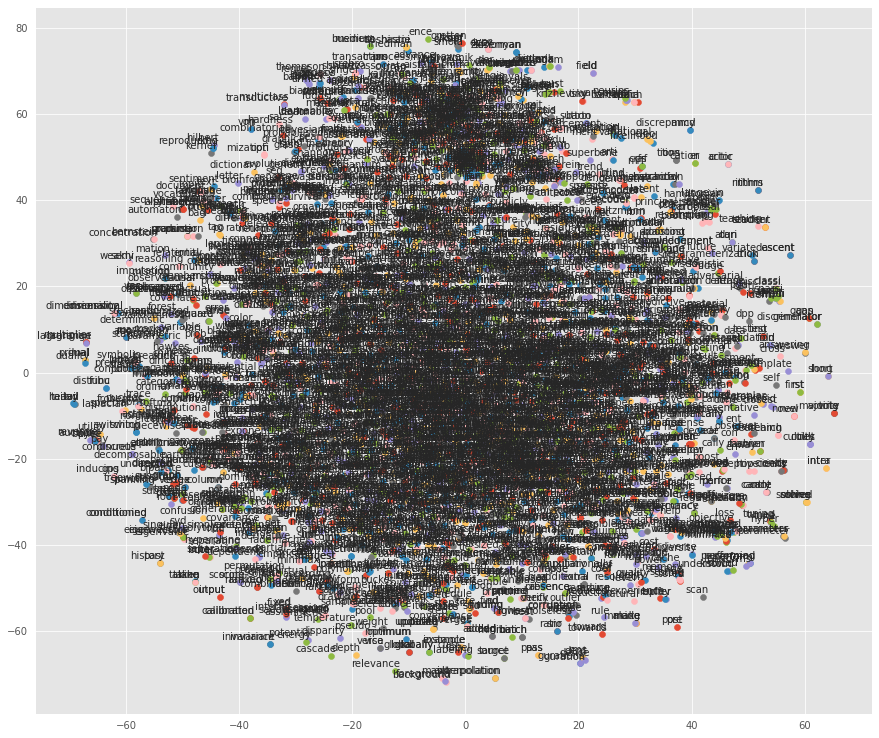

In [ ]:
tsne_plot(w2v_model)

Now let's create another model, and this time we will be using words with frequency more than 2000 and plot it using T-SNE, so that our plot looks a little more cleaner. But I believe this shouldn't be done, as words which are repeating 1000 times or more in the corpus, must have some importance, I am doing this just to show the plot a little cleaner, it is not recommended at all.

In [ ]:
w2v_model_2 = Word2Vec(tokens,
                     min_count=1000,
                     window=10,
                     size=250,
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers = 4,
                     seed=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


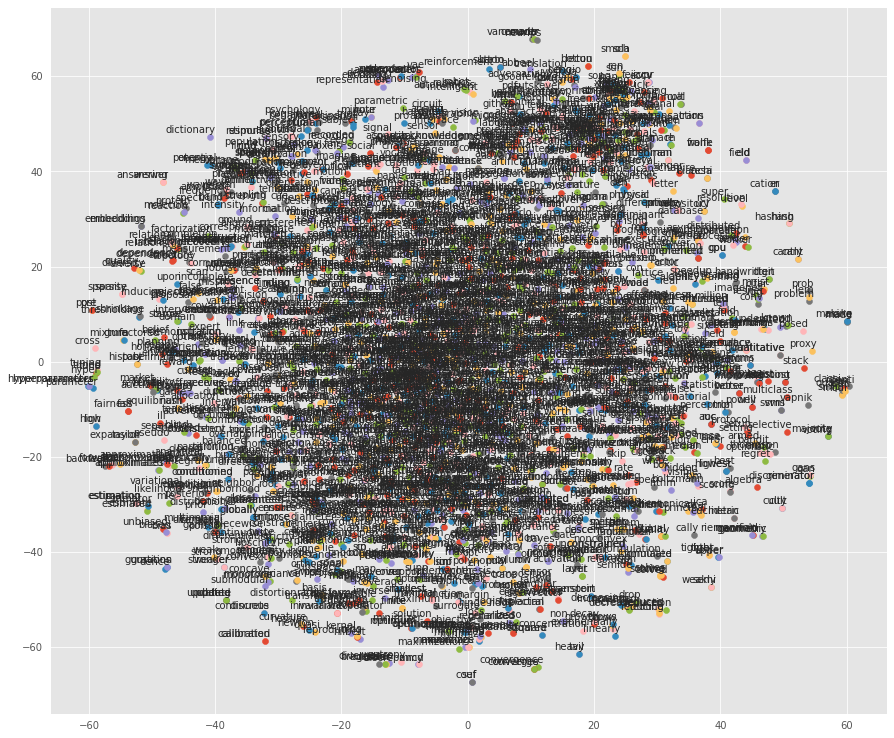

In [ ]:
tsne_plot(w2v_model_2)

**Work in progress.**